In [ ]:
! pip install ultralytics

The Basic Iterative Method (BIM) implementation reference to this article: https://www.neuralception.com/adversarialexamples-bim/

This attack method comes from Adversarial examples in the physical world paper.

In [122]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image



# Step 1: Load trained YOLOv8 model
model = YOLO('train/weights/best.pt')
image_path = 'stop.png'

# Step 2: Extract the backbone (CSPDarknet53)
backbone = model.model.model[:10]
labels = torch.tensor([22])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]
classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

image = Image.open(image_path).convert("RGB")  # Load image and ensure it's in RGB format
image = preprocess(image).unsqueeze(0)  # Apply preprocessing and add batch dimension

In [123]:
import torch
import torch.nn as nn

def bim_attack(model, images, labels, epsilon, alpha, num_iterations):
    """
    Perform the Basic Iterative Method (BIM) attack on the input images.

    Args:
        model: The model to attack.
        images: The input images to perturb.
        labels: True labels for the input images.
        epsilon: Maximum allowable perturbation.
        alpha: Step size for each iteration.
        num_iterations: Number of iterations to perform.

    Returns:
        perturbed_image: The adversarially perturbed image.
    """
    # Clone the input images to avoid modifying the original data
    perturbed_image = images.clone().detach()
    perturbed_image.requires_grad = True

    for _ in range(num_iterations):
        # Zero the gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(perturbed_image)
        
        # Compute the loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Backward pass to compute gradients
        loss.backward()
        
        # Perform a step similar to FGSM
        grad_sign = perturbed_image.grad.data.sign()
        perturbed_image = perturbed_image + alpha * grad_sign
        
        # Clip the adversarial image to maintain the epsilon constraint
        perturbed_image = torch.max(torch.min(perturbed_image, images + epsilon), images - epsilon)
        
        # Clamp to ensure pixel values are within the valid range [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        # Detach gradients to avoid accumulation
        perturbed_image = perturbed_image.clone().detach()
        perturbed_image.requires_grad = True

    return perturbed_image

# Example usage of BIM attack
epsilon = 0.1
# epsilon = 0.2
# epsilon = 0.3
alpha = 1 / 255
# alpha = 2/255
# alpha = 3/255
num_iterations = int(min(4 + epsilon / alpha, 1.25 * epsilon / alpha))
# num_iterations = int(min(10 + epsilon / alpha, 1.5 * epsilon / alpha))


bim_perturbed_image = bim_attack(classify_model, image, labels, epsilon, alpha, num_iterations)

# Use YOLO model to get output on adversarial image
# bim_boxes, bim_scores, bim_labels = get_yolo_output(model, bim_perturbed_image)


In [124]:
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls

image = torch.clamp(image, 0, 1)
boxes, scores, labels = get_yolo_output(model, image)
bim_boxes, bim_scores, bim_labels = get_yolo_output(model, bim_perturbed_image)



0: 416x416 1 Stop_Sign, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 70.2ms
Speed: 0.0ms preprocess, 70.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


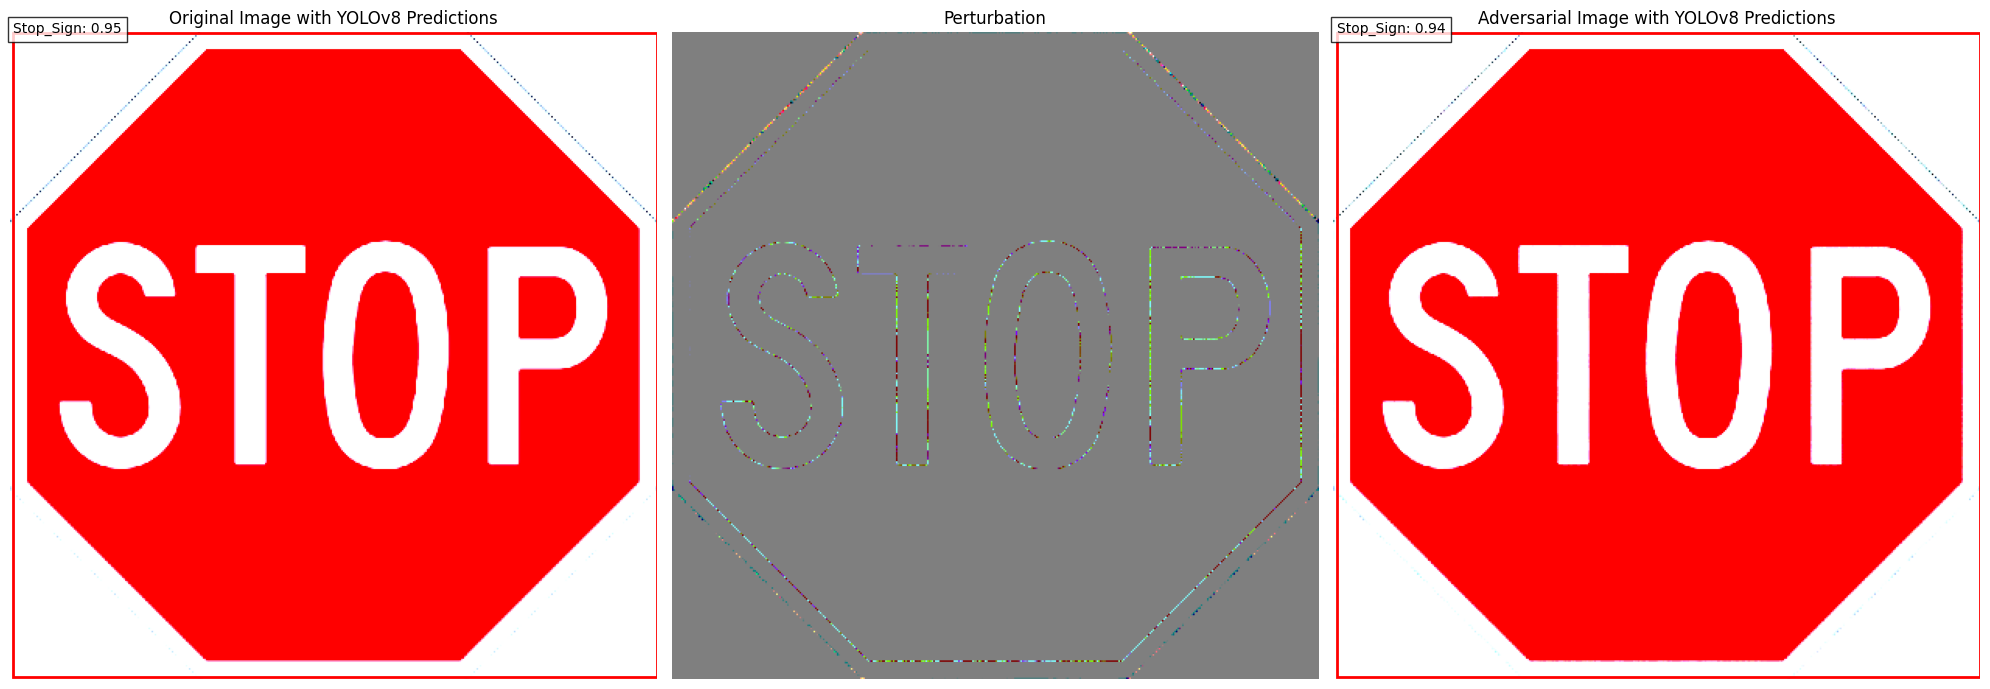

In [125]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    # Detach, remove batch dimension, permute to (height, width, channels), and convert to NumPy
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image)

# Perturbation
perturbation = (bim_perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], bim_boxes, bim_scores, bim_labels, "Adversarial Image with YOLOv8 Predictions", bim_perturbed_image)

plt.tight_layout()
plt.show()
